# How can we reduce the error in Zillow's Zestimate?

### Paddy Doran and Sean Oslin
November 12, 2019

# Project planning phase

### Project goals

1. Determine what factor(s) is driving the difference in Zestimate to sales price (i.e 'logerror').

2. Build an improved model to predict the logerror.

## Deliverables

## Acquisition, Prep, and Initial Exploration

### Data source
All data originated with the Zillow database.

### Python libraries used for analysis

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np

# Exploring
import scipy.stats as stats
from statsmodels.formula.api import ols
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, StandardScaler

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

### Python programming for this analysis imported from associated text documents¶

In [52]:
import env
df = pd.read_csv("zillow.csv")
df.head()

,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate
0,12177905,2288172,NaN,NaN,NaN,3,4,NaN,8.0,3,NaN,NaN,2376.0,2376.0,NaN,NaN,NaN,NaN,6037,NaN,3,NaN,NaN,NaN,2.0,34245180,-118240722,13038.0,1.0,NaN,NaN,NaN,1.0,0101,261,LCR110000*,6.037300e+07,396551.0,3101,NaN,96330.0,0,NaN,NaN,NaN,1,NaN,NaN,1970.0,NaN,NaN,108918.0,145143,2016,36225,1777.51,NaN,NaN,6.037300e+13,-0.103410,2017-01-01
1,10887214,1970746,1.0,NaN,NaN,3,3,NaN,8.0,3,NaN,NaN,1312.0,1312.0,NaN,NaN,NaN,NaN,6037,NaN,3,NaN,NaN,NaN,2.0,34185120,-118414640,278581.0,1.0,NaN,NaN,NaN,1.0,010C,266,LAR3,6.037124e+07,12447.0,3101,268548.0,96451.0,0,NaN,NaN,NaN,1,NaN,NaN,1964.0,NaN,NaN,73681.0,119407,2016,45726,1533.89,NaN,NaN,6.037124e+13,0.006940,2017-01-01
2,12095076,781532,1.0,NaN,NaN,3,4,NaN,9.0,3,NaN,NaN,2962.0,2962.0,NaN,NaN,NaN,NaN,6037,NaN,3,NaN,NaN,NaN,2.0,34145202,-118179824,63000.0,1.0,NaN,NaN,NaN,1.0,0101,261,PSR2,6.037461e+07,47019.0,3101,274684.0,96293.0,0,NaN,NaN,NaN,1,NaN,NaN,1950.0,NaN,NaN,276684.0,773303,2016,496619,9516.26,NaN,NaN,6.037461e+13,-0.001011,2017-01-01
3,12069064,870991,NaN,NaN,NaN,1,2,NaN,5.0,1,NaN,NaN,738.0,738.0,NaN,NaN,NaN,NaN,6037,NaN,1,NaN,NaN,NaN,NaN,34149214,-118239357,4214.0,NaN,NaN,NaN,NaN,NaN,0100,261,GLR4YY,6.037302e+07,45457.0,3101,276258.0,96325.0,0,NaN,NaN,NaN,1,NaN,NaN,1922.0,NaN,NaN,18890.0,218552,2016,199662,2366.08,NaN,NaN,6.037302e+13,0.101723,2017-01-01
4,12790562,1246926,NaN,NaN,NaN,3,4,NaN,9.0,3,NaN,NaN,3039.0,3039.0,NaN,NaN,NaN,NaN,6037,NaN,3,NaN,NaN,NaN,2.0,33960230,-118006914,20028.0,NaN,NaN,NaN,NaN,NaN,0100,261,WHRE20000*,6.037500e+07,14634.0,3101,NaN,96173.0,0,NaN,NaN,NaN,1,NaN,NaN,1970.0,NaN,NaN,177527.0,220583,2016,43056,3104.19,NaN,NaN,6.037500e+13,-0.040966,2017-01-02


## Data preparation

#### Force 'head' to show all columns

In [4]:
pd.set_option('display.max_columns', None) 

#### Remove duplicate columns

In [5]:
def remove_dup_col(df):
    df = df.loc[:,~df.columns.duplicated()]
    return df

In [6]:
df = remove_dup_col(df)

#### Calculate the number and percent of missing values for each attribute

In [7]:
# def df2(df):
#     num_rows_missing = df.isna().sum()
#     pct_rows_missing = num_rows_missing/len(df)*100
#     df_sum = pd.DataFrame()
#     df_sum['num_rows_missing'] = num_rows_missing
#     df_sum['pct_rows_missing'] = pct_rows_missing
#     return df_sum

In [8]:
# df2(df)

#### Delete rows and columns with excessing missing values

In [9]:
def handle_missing_values(df, prop_required_column = .9, prop_required_row = .75):
    threshold = int(round(prop_required_column*len(df.index),0))
    df.dropna(axis=1, thresh=threshold, inplace=True)
    threshold = int(round(prop_required_row*len(df.columns),0))
    df.dropna(axis=0, thresh=threshold, inplace=True)
    return df


def data_prep(df, cols_to_remove=[], prop_required_column=.9, prop_required_row=.75):
    df.drop(columns = cols_to_remove)
    df = handle_missing_values(df, prop_required_column, prop_required_row)
    return df

In [10]:
df = data_prep(df, cols_to_remove=[], prop_required_column=.9, prop_required_row=.75)

#### Drop unneeded columns

In [13]:
def drop_col(df):
        df = df.drop(columns = ['calculatedbathnbr', 'finishedsquarefeet12', 'fullbathcnt', 'propertycountylandusecode',
                            'propertylandusetypeid', 'rawcensustractandblock', 'regionidcity', 'regionidzip', 
                            'censustractandblock', 'transactiondate', 'assessmentyear',
                            'roomcnt', 'regionidcounty'])
        return df

In [53]:
df = drop_col(df)

KeyError: "['parcelid_outliers' 'id_outliers' 'bathroomcnt_outliers'\n 'bedroomcnt_outliers' 'buildingqualitytypeid_outliers'\n 'calculatedfinishedsquarefeet_outliers' 'fips_outliers'\n 'heatingorsystemtypeid_outliers' 'latitude_outliers' 'longitude_outliers'\n 'lotsizesquarefeet_outliers' 'unitcnt_outliers' 'yearbuilt_outliers'\n 'structuretaxvaluedollarcnt_outliers' 'taxvaluedollarcnt_outliers'\n 'landtaxvaluedollarcnt_outliers' 'logerror_outliers'] not found in axis"

### Manage missing values

For land square feet, impute the missing values by creating a linear model where landtaxvaluedollarcnt is the x-variable and the output/y-variable is the estimated land square feet.

In [15]:
x = df['landtaxvaluedollarcnt']
y = df['lotsizesquarefeet']
ols_model = ols('lotsizesquarefeet ~ landtaxvaluedollarcnt', data=df).fit()

df['yhat'] = ols_model.predict(df[['landtaxvaluedollarcnt']])

In [16]:
# Use y when we have y, if y is NaN, use yhat
df.lotsizesquarefeet = np.where(df.lotsizesquarefeet.isna(), df.yhat, df.lotsizesquarefeet)

In [17]:
def impute_values(df):
    sqfeet = df.calculatedfinishedsquarefeet.median()
    df.calculatedfinishedsquarefeet = df.calculatedfinishedsquarefeet.fillna(sqfeet)
    
    structuretaxvalue = df.structuretaxvaluedollarcnt.median()
    df.structuretaxvaluedollarcnt = df.structuretaxvaluedollarcnt.fillna(structuretaxvalue)
    
    taxvalue = df.taxvaluedollarcnt.median()
    df.taxvaluedollarcnt = df.taxvaluedollarcnt.fillna(taxvalue)
    
    landtaxvalue = df.landtaxvaluedollarcnt.median()
    df.landtaxvaluedollarcnt = df.landtaxvaluedollarcnt.fillna(landtaxvalue)
    
    return df

In [18]:
x = df['taxvaluedollarcnt']
y = df['taxamount']
ols_model = ols('lotsizesquarefeet ~ taxvaluedollarcnt', data=df).fit()

df['yhat'] = ols_model.predict(df[['taxvaluedollarcnt']])

In [19]:
# use y when we have y, if y is NaN, use yhat
df.taxamount = np.where(df.taxamount.isna(), df.yhat, df.taxamount)

#### Drop rows with no 'yearbuilt' date

In [20]:
df.fillna(value=pd.np.nan, inplace=True)

In [21]:
df = df.dropna()

In [22]:
def drop_col2(df): #Drop additional columns that are no longer of use. 
        df = df.drop(columns = ['taxamount', 'yhat'])
        return df

In [23]:
df = drop_col2(df)

#### Adjust data types

In [24]:
df[['bathroomcnt', 'calculatedfinishedsquarefeet', 'bedroomcnt','fips', 'latitude', 'longitude', 'lotsizesquarefeet', 'yearbuilt', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt']] =df[['bathroomcnt', 'calculatedfinishedsquarefeet', 'bedroomcnt','fips', 'latitude', 'longitude', 'lotsizesquarefeet', 'yearbuilt', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt']].astype('int64')

#### Manage outliers

Upper outliers

In [25]:
def get_upper_outliers(s, k):
    q1, q3 = s.quantile([.25, .75])
    iqr = q3 - q1
    upper_bound = q3 + k * iqr
    return s.apply(lambda x: max([x - upper_bound, 0]))

def add_upper_outlier_columns(df, k):
    outlier_cols = {col + '_outliers': get_upper_outliers(df[col], k)
                   for col in df.select_dtypes('number')}
    return df.assign(**outlier_cols)
    for col in df.select_dtypes('number'):
        df[col + '_outliers'] = get_upper_outliers(df[col], k)

    return df

add_upper_outlier_columns(df, k=4)

,parcelid,id,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,propertyzoningdesc,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,logerror,parcelid_outliers,id_outliers,bathroomcnt_outliers,bedroomcnt_outliers,buildingqualitytypeid_outliers,calculatedfinishedsquarefeet_outliers,fips_outliers,heatingorsystemtypeid_outliers,latitude_outliers,longitude_outliers,lotsizesquarefeet_outliers,unitcnt_outliers,yearbuilt_outliers,structuretaxvaluedollarcnt_outliers,taxvaluedollarcnt_outliers,landtaxvaluedollarcnt_outliers,logerror_outliers
0,12177905,2288172,3,4,8.0,2376,6037,2.0,34245180,-118240722,13038,LCR110000*,1,1970,108918,145143,36225,-0.103410,0.0,0,0.0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.000000
1,10887214,1970746,3,3,8.0,1312,6037,2.0,34185120,-118414640,278581,LAR3,1,1964,73681,119407,45726,0.006940,0.0,0,0.0,0,0,0.0,0.0,0,0,0,206352.0,0.0,0,0.0,0.0,0.0,0.000000
2,12095076,781532,3,4,9.0,2962,6037,2.0,34145202,-118179824,63000,PSR2,1,1950,276684,773303,496619,-0.001011,0.0,0,0.0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.000000
4,12790562,1246926,3,4,9.0,3039,6037,2.0,33960230,-118006914,20028,WHRE20000*,1,1970,177527,220583,43056,-0.040966,0.0,0,0.0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.000000
5,11542646,1585097,3,2,8.0,1290,6037,2.0,33998800,-118416000,54048,LAR3,1,1980,151303,371361,220058,-0.036763,0.0,0,0.0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.000000
6,11104527,1639362,3,4,8.0,2540,6037,2.0,34434971,-118464390,10384,SCUR2,1,1999,271715,430108,158393,0.005963,0.0,0,0.0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.000000
7,12045625,1169121,3,3,8.0,1435,6037,2.0,34212400,-118238000,45171,GLR3*,1,1981,169727,259197,89470,-0.017167,0.0,0,0.0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.000000
8,11830315,571930,1,2,4.0,1146,6037,7.0,34024040,-118159090,4657,LCR2YY,1,1939,127960,273745,145785,-0.035085,0.0,0,0.0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.000000
9,12325145,2542130,2,3,6.0,1092,6037,2.0,33897676,-118169106,36005,PARM*,1,1979,140581,178646,38065,0.042463,0.0,0,0.0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.000000
11,11671335,1690166,3,2,9.0,2126,6037,2.0,34074859,-118563050,221601,LARD3,1,1983,276641,573247,296606,-0.000546,0.0,0,0.0,0,0,0.0,0.0,0,0,0,149372.0,0.0,0,0.0,0.0,0.0,0.000000


In [26]:
new_df = add_upper_outlier_columns(df, k = 4.0)
outlier_cols = [col for col in new_df if col.endswith('_outliers')]
for col in outlier_cols:
    print('~~~\n' + col)
    data = new_df[col][new_df[col] > 0]
    print(data.describe())
    new_df = new_df[(new_df.logerror_outliers ==0) & (new_df.lotsizesquarefeet_outliers == 0)]
    new_df = new_df[(new_df.bathroomcnt_outliers == 0) & (new_df.calculatedfinishedsquarefeet_outliers == 0) & (new_df.calculatedfinishedsquarefeet_outliers == 0)]
    new_df = new_df[(new_df.structuretaxvaluedollarcnt_outliers == 0) & (new_df.taxvaluedollarcnt_outliers == 0) & (new_df.landtaxvaluedollarcnt_outliers == 0)]
    


~~~
parcelid_outliers
count    1.600000e+01
mean     1.497421e+08
std      4.776622e+03
min      1.497398e+08
25%      1.497404e+08
50%      1.497408e+08
75%      1.497419e+08
max      1.497597e+08
Name: parcelid_outliers, dtype: float64
~~~
id_outliers
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: id_outliers, dtype: float64
~~~
bathroomcnt_outliers
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: bathroomcnt_outliers, dtype: float64
~~~
bedroomcnt_outliers
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: bedroomcnt_outliers, dtype: float64
~~~
buildingqualitytypeid_outliers
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: buildingqualitytypeid_outliers, dtype: float64
~~~
calculatedfinishedsquarefeet_outliers
count    0.0
mean     NaN
std   

Lower outliers

In [27]:
def get_lower_outliers(s, k):
    q1, q3 = s.quantile([.25, .75])
    iqr = q3 - q1
    lower_bound = q1- k * iqr
    return s.apply(lambda x: x if x < lower_bound else 0)

def add_lower_outlier_columns(df, k):
    outlier_cols = {col + '_outliers': get_lower_outliers(df[col], k)
                     for col in df.select_dtypes('number')}
    return df.assign(**outlier_cols)
    for col in df.select_dtypes('number'):
        df[col + '_outliers'] = get_lower_outliers(df3[col], k)

    return df

add_lower_outlier_columns(df, k=4)

,parcelid,id,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,propertyzoningdesc,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,logerror,parcelid_outliers,id_outliers,bathroomcnt_outliers,bedroomcnt_outliers,buildingqualitytypeid_outliers,calculatedfinishedsquarefeet_outliers,fips_outliers,heatingorsystemtypeid_outliers,latitude_outliers,longitude_outliers,lotsizesquarefeet_outliers,unitcnt_outliers,yearbuilt_outliers,structuretaxvaluedollarcnt_outliers,taxvaluedollarcnt_outliers,landtaxvaluedollarcnt_outliers,logerror_outliers
0,12177905,2288172,3,4,8.0,2376,6037,2.0,34245180,-118240722,13038,LCR110000*,1,1970,108918,145143,36225,-0.103410,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000
1,10887214,1970746,3,3,8.0,1312,6037,2.0,34185120,-118414640,278581,LAR3,1,1964,73681,119407,45726,0.006940,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000
2,12095076,781532,3,4,9.0,2962,6037,2.0,34145202,-118179824,63000,PSR2,1,1950,276684,773303,496619,-0.001011,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000
4,12790562,1246926,3,4,9.0,3039,6037,2.0,33960230,-118006914,20028,WHRE20000*,1,1970,177527,220583,43056,-0.040966,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000
5,11542646,1585097,3,2,8.0,1290,6037,2.0,33998800,-118416000,54048,LAR3,1,1980,151303,371361,220058,-0.036763,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000
6,11104527,1639362,3,4,8.0,2540,6037,2.0,34434971,-118464390,10384,SCUR2,1,1999,271715,430108,158393,0.005963,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000
7,12045625,1169121,3,3,8.0,1435,6037,2.0,34212400,-118238000,45171,GLR3*,1,1981,169727,259197,89470,-0.017167,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000
8,11830315,571930,1,2,4.0,1146,6037,7.0,34024040,-118159090,4657,LCR2YY,1,1939,127960,273745,145785,-0.035085,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000
9,12325145,2542130,2,3,6.0,1092,6037,2.0,33897676,-118169106,36005,PARM*,1,1979,140581,178646,38065,0.042463,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000
11,11671335,1690166,3,2,9.0,2126,6037,2.0,34074859,-118563050,221601,LARD3,1,1983,276641,573247,296606,-0.000546,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000


#### Drop outlier columns

In [28]:
def drop_col(new_df):
    new_df = new_df.drop(columns = [
           'parcelid_outliers', 'id_outliers', 'bathroomcnt_outliers',
           'bedroomcnt_outliers', 'buildingqualitytypeid_outliers',
           'calculatedfinishedsquarefeet_outliers', 'fips_outliers',
           'heatingorsystemtypeid_outliers', 'latitude_outliers',
           'longitude_outliers', 'lotsizesquarefeet_outliers', 'unitcnt_outliers',
           'yearbuilt_outliers', 'structuretaxvaluedollarcnt_outliers',
           'taxvaluedollarcnt_outliers', 'landtaxvaluedollarcnt_outliers',
           'logerror_outliers', 'propertyzoningdesc', 'buildingqualitytypeid', 'heatingorsystemtypeid'])
    return new_df

In [29]:
new_df = drop_col(new_df)

In [54]:
train, test = train_test_split(new_df, test_size=.30)

#### Encode the bathroom and bedroom counts

In [55]:
def one_hot_encode(train, test, col_name):

    encoded_values = sorted(list(train[col_name].unique()))

    train_array = np.array(train[col_name]).reshape(len(train[col_name]),1)
    test_array = np.array(test[col_name]).reshape(len(test[col_name]),1)

    ohe = OneHotEncoder(sparse=False, categories='auto')
    train_ohe = ohe.fit_transform(train_array)
    test_ohe = ohe.transform(test_array)

    train_encoded = pd.DataFrame(data=train_ohe,
                            columns=encoded_values, index=train.index)
    train = train.join(train_encoded)

    test_encoded = pd.DataFrame(data=test_ohe,
                            columns=encoded_values, index=test.index)
    test = test.join(test_encoded)

    return train, test

In [32]:
train, test = one_hot_encode(train, test, col_name = 'bathroomcnt')

In [33]:
train.rename(columns={1:'1bath', 2:'2bath', 3:'3bath', 4: '4bath', 5:'5bath', 6:'6bath', 7: '7bath'}, inplace=True)
test.rename(columns={1:'1bath', 2:'2bath', 3:'3bath', 4: '4bath', 5:'5bath', 6:'6bath', 7: '7bath'}, inplace=True)

In [35]:
train, test = one_hot_encode(train, test, col_name = 'bedroomcnt')

In [36]:
train.rename(columns={1:'1bed', 2:'2bed', 3:'3bed', 4: '4bed', 5:'5bed', 6:'6bed', 7: '7bed', 8: '8bed', 9:'9bed'}, inplace=True)
test.rename(columns={1:'1bed', 2:'2bed', 3:'3bed', 4: '4bed', 5:'5bed', 6:'6bed', 7: '7bed', 8: '8bed', 9:'9bed'}, inplace=True)

,index,parcelid,id,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,logerror,1bath,2bath,3bath,4bath,5bath,6bath,7bath,1bed,2bed,3bed,4bed,5bed,6bed,7bed,8bed,9bed
0,4374,11324186,1490682,2455,6037,34564476,-118169237,5292,1,2005,218214,291095,72881,-0.006111,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,29279,11361393,2776932,1740,6037,34445754,-118658646,5498,1,1989,175936,327227,151291,0.006409,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,68,12350928,2572071,1901,6037,33934976,-118110193,6693,1,1950,126000,635000,509000,0.118421,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,42083,12038234,2451418,1956,6037,34116899,-118277150,6496,1,1954,227817,1139087,911270,-0.015239,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10199,12851126,2350439,1515,6037,33984246,-117886311,5726,1,1983,119426,203525,84099,-0.081038,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,43074,10998962,449868,1686,6037,34254932,-118316872,6087,1,1949,160600,538000,377400,0.019142,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6,33487,12085466,751721,840,6037,34145916,-118235472,5016,1,1915,3372,36064,32692,0.117056,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,5361,12467566,1290335,1032,6037,33823082,-118172928,4564,1,1929,156485,423037,266552,-0.094636,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,16192,12386454,1737483,1662,6037,33958324,-118113664,6092,1,1928,103800,520000,416200,0.005568,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9,26065,12232520,1229650,1452,6037,33937516,-118249010,7692,1,1925,74823,223354,148531,-0.017334,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
train.reset_index(drop = True, inplace = True)
test.reset_index(inplace = True)

In [39]:
scaler = StandardScaler()

train_scaled = train.copy()
test_scaled = test.copy()

train_scaled = train_scaled[['calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt']]
test_scaled = test_scaled[['calculatedfinishedsquarefeet', 'lotsizesquarefeet','structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt']]
scaler.fit(train_scaled)
scaler.fit(test_scaled)
train_scaled = scaler.transform(train_scaled)
test_scaled = scaler.transform(test_scaled)                   

In [40]:
train_scaled = pd.DataFrame(train_scaled)
train_scaled.columns =['calculatedfinishedsquarefeet', 'lotsizesquarefeet','structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt']
test_scaled = pd.DataFrame(test_scaled)
test_scaled.columns =['calculatedfinishedsquarefeet', 'lotsizesquarefeet','structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt']

In [41]:
train_scaled.head()

,calculatedfinishedsquarefeet,lotsizesquarefeet,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt
0,-0.021661,-0.521744,0.311873,0.260145,0.189718
1,-0.902833,-0.342727,-0.797278,-1.034205,-0.971456
2,-0.476505,-0.421126,-0.806414,-0.209026,0.120388
3,1.144679,-0.413010,1.972769,1.428679,0.914276
4,-0.080121,-0.522847,-0.149661,0.379113,0.573028


In [42]:
train[['calculatedfinishedsquarefeet', 'lotsizesquarefeet','structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt']]= train_scaled[['calculatedfinishedsquarefeet', 'structuretaxvaluedollarcnt', 'lotsizesquarefeet','taxvaluedollarcnt', 'landtaxvaluedollarcnt']]
train.head()

,parcelid,id,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,logerror,1bath,2bath,3bath,4bath,5bath,6bath,7bath,1bed,2bed,3bed,4bed,5bed,6bed,7bed,8bed,9bed
0,11169723,2165446,2,2,-0.021661,6037,34398981,-118554366,0.311873,1,1987,-0.521744,0.260145,0.189718,-0.086453,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,11277808,2925803,1,2,-0.902833,6037,34702177,-118152019,-0.797278,1,1953,-0.342727,-1.034205,-0.971456,-0.006782,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,12370807,2065380,1,2,-0.476505,6037,34008134,-118117158,-0.806414,1,1925,-0.421126,-0.209026,0.120388,0.022873,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,12072190,2585767,4,3,1.144679,6037,34168438,-118245692,1.972769,1,1984,-0.413010,1.428679,0.914276,0.050392,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11729584,2226985,1,3,-0.080121,6037,34027982,-118312772,-0.149661,1,1909,-0.522847,0.379113,0.573028,-0.208344,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Create dependent variable 'logerror'

In [43]:
X_train = train.drop(columns ='logerror')
y_train = train[['logerror']]
X_test = test.drop(columns ='logerror')
y_test = test[['logerror']]

#### Create clusters

In [44]:
def target_cluster(y_train,X_train):
    kmeans = KMeans(n_clusters=5)
    kmeans.fit(y_train)
    y_train['cluster'] = kmeans.predict(y_train)
    train = X_train.merge(y_train,left_index=True,right_index=True)
    return train, kmeans


In [45]:
X_train, kmeans = target_cluster(y_train,X_train)

In [46]:
X_train.groupby(['cluster']).mean().sort_values('logerror')

,parcelid,id,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,1bath,2bath,3bath,4bath,5bath,6bath,7bath,1bed,2bed,3bed,4bed,5bed,6bed,7bed,8bed,9bed,logerror
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,1.162012e+07,1.218134e+06,2.166667,2.833333,0.211464,6037.0,3.409228e+07,-1.182738e+08,-0.007140,1.0,1976.500000,0.397836,-0.073296,-0.093080,0.166667,0.500000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.500000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,-3.264073
1,1.175279e+07,1.466690e+06,1.929907,2.733645,-0.058054,6037.0,3.406852e+07,-1.183156e+08,-0.074516,1.0,1945.392523,-0.089232,0.213381,0.317754,0.406542,0.350467,0.172897,0.051402,0.014019,0.004673,0.000000,0.060748,0.401869,0.345794,0.144860,0.028037,0.018692,0.000000,0.000000,0.000000,-0.586031
4,1.190234e+07,1.515238e+06,2.025065,2.886563,-0.102393,6037.0,3.410567e+07,-1.182602e+08,-0.088926,1.0,1956.006977,-0.043086,-0.007511,0.033752,0.282171,0.465375,0.206977,0.036951,0.007752,0.000775,0.000000,0.034367,0.302584,0.450388,0.176227,0.029457,0.005426,0.001292,0.000258,0.000000,-0.113310
0,1.189783e+07,1.496993e+06,2.194663,3.026785,-0.002719,6037.0,3.411316e+07,-1.182468e+08,0.033901,1.0,1965.236849,0.008088,0.007772,-0.006399,0.203456,0.463939,0.280356,0.040407,0.010470,0.001321,0.000051,0.031614,0.247776,0.442745,0.225362,0.045896,0.005896,0.000610,0.000102,0.000000,0.006889
2,1.191205e+07,1.524368e+06,2.215071,3.072841,0.116279,6037.0,3.409734e+07,-1.182558e+08,-0.024163,1.0,1959.424490,-0.010871,-0.001741,0.009566,0.234537,0.428571,0.253375,0.059655,0.019466,0.003454,0.000942,0.036107,0.251805,0.416327,0.215699,0.064364,0.012245,0.002198,0.000628,0.000628,0.139155


In [47]:
kmeans.cluster_centers_

array([[ 0.00686837],
       [-0.58603122],
       [ 0.13923762],
       [-3.26407275],
       [-0.11348114]])

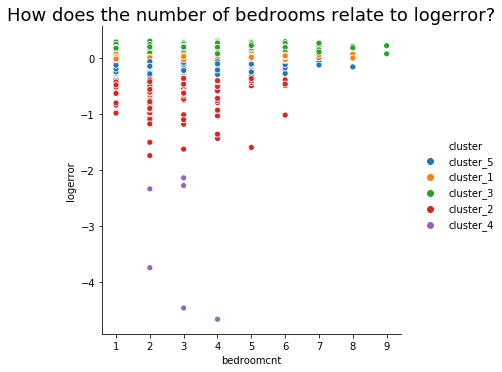

In [80]:
kmeans = KMeans(n_clusters=5).fit(y_train)
y_train['cluster'] = kmeans.predict(y_train)
# X_train.cluster = 'cluster_' + (X_train.cluster + 1).astype('str')
sns.relplot(data=X_train, x='bedroomcnt', y='logerror', hue='cluster')
plt.title('How does the number of bedrooms relate to logerror?', fontsize = 18)
plt.show()

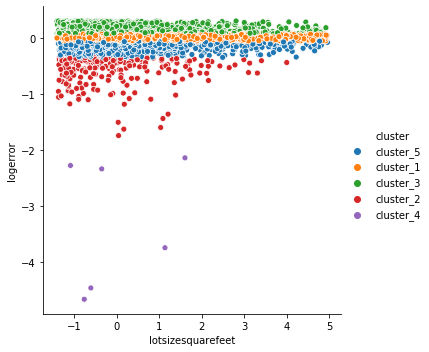

In [72]:
y_train['cluster'] = kmeans.predict(y_train)
sns.relplot(data=X_train, x='lotsizesquarefeet', y='logerror', hue='cluster')
plt.show()

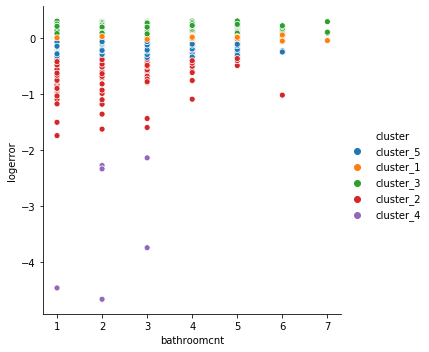

In [73]:
y_train['cluster'] = kmeans.predict(y_train)
sns.relplot(data=X_train, x='bathroomcnt', y='logerror', hue='cluster')
plt.show()

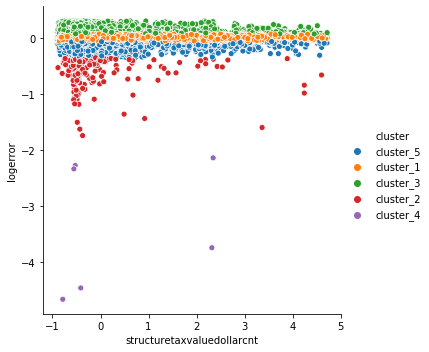

In [74]:
y_train['cluster'] = kmeans.predict(y_train)
sns.relplot(data=X_train, x='structuretaxvaluedollarcnt', y='logerror', hue='cluster')
plt.show()

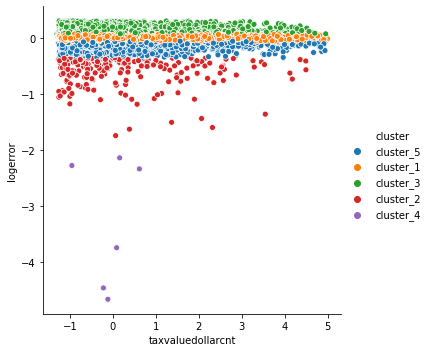

In [75]:
y_train['cluster'] = kmeans.predict(y_train)
sns.relplot(data=X_train, x='taxvaluedollarcnt', y='logerror', hue='cluster')
plt.show()

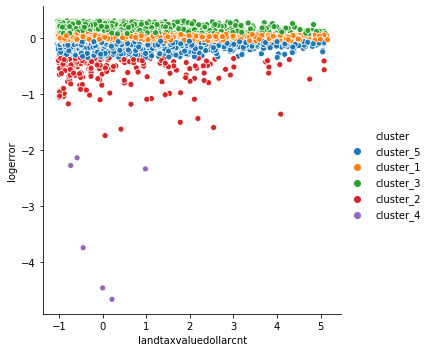

In [76]:
y_train['cluster'] = kmeans.predict(y_train)
sns.relplot(data=X_train, x='landtaxvaluedollarcnt', y='logerror', hue='cluster')
plt.show()

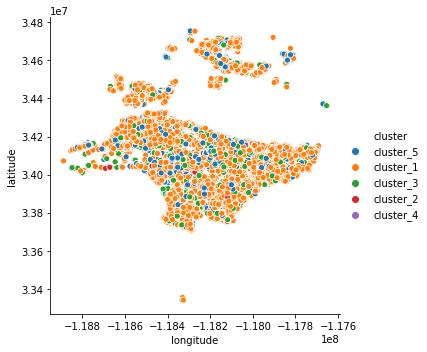

In [77]:
y_train['cluster'] = kmeans.predict(y_train)
sns.relplot(data=X_train, x='longitude', y='latitude', hue='cluster')
plt.show()

In [ ]:
train.drop(columns = (['bathroomcnt', 'bedroomcnt']))
test.drop(columns = (['bathroomcnt', 'bedroomcnt']))